### Imports necesarios

In [1]:
# Useful libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

# Metrics.
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn import metrics

# To prevent some warnings.
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)

### Miscellaneous functions

In [2]:
# Read a cut of the dataset, it assumes that there is going to be four files in the directory,
#   called "xTrain", "xTest", "yTrain", "yTest".
def readCut(dir):
    xTrain = pd.read_csv("{}/xTrain.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    yTrain = pd.read_csv("{}/yTrain.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    xTest  = pd.read_csv( "{}/xTest.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    yTest  = pd.read_csv( "{}/yTest.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")

    return xTrain, yTrain, xTest, yTest

# Entries names for the result dictionary.
_accuracy   = "Accuracy"
_precision  = "Precision"
_recall     = "Recall"
_f1         = "F1"
_auc        = "AUC"
_model      = "Model"
_min_iter   = "min_cut_iter" 
_max_iter   = "max_cut_iter" 
_model_min  = "model_min"
_model_max  = "model_max"

#Dictionary for visualization ROC
_vis_minMetrics  =   "minMetrics" 
_vis_minModel    =   "minModel" 
_vis_maxMetrics  =   "maxMetrics"
_vis_maxModel    =   "maxModel" 
_vis_pathMin     =   "pathMin"  
_vis_pathMax     =   "pathMax"  

# Metrics array.
_metrics = [_accuracy, _precision, _recall, _f1, _auc]

# Names of the feature enginereed datastes.
_normalized   = "Normalized"
_standardized = "Standardized"
_betterFE     = "BetterFE"

# Datasets array.
_datasets = [_normalized, _standardized, _betterFE]

# Entries names for the calculated results.
_min  = "Min"
_max  = "Max"
_mean = "Mean"

# Function to process the results of a model, to get a better print of them.
def processAlgorithmResults(resultDictionary):

    # Result dictionary
    calculatedResultsDictionary = {}
    # Process the results for every feature engineed dataset.
    for dataset in _datasets:
        # Set the current dataset entry.
        calculatedResultsDictionary[dataset] = {}

        # Process every metric.
        for metric in _metrics:
            # Store the metric values.
            metricValues = []
            classifiers = []

            # Process the results for every cut.
            for cut in resultDictionary[dataset]:
                # Get the specific metric value for the current cut.
                metricValues.append(cut[metric])
                classifiers.append(cut[_model])

            # Get the calculated results.
            min_it = np.argmin(metricValues)
            max_it = np.argmax(metricValues)
            calculatedResultsDictionary[dataset][metric] = {
                _min        : min(metricValues),
                _max        : max(metricValues),
                _mean       : sum(metricValues) / len(metricValues),
                _min_iter   : int(min_it + 1),
                _max_iter   : int(max_it + 1),
                _model_min  : classifiers[min_it],
                _model_max  : classifiers[max_it]
            }

    return calculatedResultsDictionary

# Print the calculated results in a tabular form from the calculated results dictionary.
def plotCalculatedResults(calculatedResults):
    # Print the results for every dataset.
    for dataset in _datasets:

        print(dataset, "dataset metrics summary")

        # Create a panda frame to pretty print.
        frame = pd.DataFrame(calculatedResults[dataset])
        
        # Delete models and indices for pretty print
        frame.drop(_model_min, inplace=True)
        frame.drop(_model_max, inplace=True)
        frame.drop(_min_iter, inplace=True)
        frame.drop(_max_iter, inplace=True)

        # Print the frame.
        print(frame)
        print()

# Plot the ROC curve for every dataset, two plots, for the min and max AUC-valued cuts.
def plotROC(calculatedResults, fullDicc):
    # Plot the ROC for every feature engineed dataset.
    for dataset in _datasets:

        print(dataset, "dataset ROC for min and max AUC value")
        
        # Get the model and data for the min AUC-value cut.
        cut_with_min_value  = calculatedResults[dataset][_auc][_min_iter]
        model_min =calculatedResults[dataset][_auc][_model_min]
        pathMin = os.path.join(dataset, "cut" + str(cut_with_min_value))

        # Get the model and data for the max AUC-value cut.
        cut_with_max_value  = calculatedResults[dataset][_auc][_max_iter]
        model_max =calculatedResults[dataset][_auc][_model_max]
        pathMax = os.path.join(dataset, "cut" + str(cut_with_max_value))
        
        # Get all the metrics for the two cuts.
        metric_values_min = {}
        metric_values_max = {}
        for metrics in _metrics:
            metric_values_min[metrics] = fullDicc[dataset][cut_with_min_value - 1][metrics]
            metric_values_max[metrics] = fullDicc[dataset][cut_with_max_value - 1][metrics]

        # Build the result.
        dicc_plot = {
            _vis_minMetrics : metric_values_min,
            _vis_minModel   : model_min,
            _vis_maxMetrics : metric_values_max,
            _vis_maxModel   : model_max,
            _vis_pathMin    : pathMin,
            _vis_pathMax    : pathMax
        }
        
        plotVis(dicc_plot)

# Auxiliary function to plot the ROC.
def plotVis(diccionary):
    print("Min AUC-valued cut")

    # Get the model, path and metrics from the parameter.
    metrics = diccionary[_vis_minMetrics]
    model = diccionary[_vis_minModel]
    path = diccionary[_vis_pathMin]

    # Print the metrics.
    print(metrics)

    # Read the data again.
    xTrain, yTrain, xTest, yTest = readCut(path)
    # Plot the ROC.
    plot_roc_curve(model, xTest, yTest)
    plt.show(block = False)
    
    print("Max AUC-valued cut")

    # Get the model, path and metrics from the parameter.
    metrics = diccionary[_vis_maxMetrics]
    model = diccionary[_vis_maxModel]
    path = diccionary[_vis_pathMax]
    
    # Print the metrics.
    print(metrics)

    # Read the data again.
    xTrain, yTrain, xTest, yTest = readCut(path)
    
    # Plot the ROC.
    plot_roc_curve(model, xTest, yTest)
    plt.show(block = False)

# Definition of the models
Each of the following functions is responsible for instantiating the model, defining the parameter grid to find the best parameters, and training the model with the best parameters to make predictions and calculate metrics.

### Logistic Regression

In [3]:
def doLogisticRegression(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    logisticRegression = LogisticRegression()

    # Definition of the parameter grid.
    param_grid = [{'penalty':['l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter':[100, 500, 1000],
                'fit_intercept' : [True, False]
    }]
    logreg_cv = GridSearchCV(logisticRegression, param_grid, n_jobs=-1)
    
    # Fit the model.
    logreg_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", logreg_cv.best_params_)

    # Predict using the model.
    yPred = logreg_cv.predict(xTest)
   
    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : logreg_cv
    }

    return dicResult


### K-Nearest-Neighbor

In [4]:
def doKNN(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    knn = KNeighborsClassifier()

    # Definition of the parameter grid.
    param_grid = [{'n_neighbors':[i for i in range(3,11)],
                'weights' : ['uniform', 'distance'],
                'algorithm' : ['ball_tree', 'kd_tree'],
                'leaf_size' : [i for i in range(20,41)],
                'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }]
    knn_cv=GridSearchCV(knn, param_grid, n_jobs=-1)

    # Fit the model.
    knn_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", knn_cv.best_params_)

    # Predict using the model.
    yPred = knn_cv.predict(xTest)
   
    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : knn_cv
    }

    return dicResult

### Decision Tree

In [5]:
def doDecisionTree(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    decisionTree = DecisionTreeClassifier()

    # Definition of the parameter grid.
    param_grid = [{'criterion':['gini', 'entropy'],
                'max_depth': np.arange(3,15).tolist() + [None],
                'splitter' : ['best', 'random'],
                'max_features' : ['sqrt', 'log2', None]
    }]
    decisionTree_cv=GridSearchCV(decisionTree, param_grid, n_jobs=-1)

    # Fit the model.
    decisionTree_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", decisionTree_cv.best_params_)

    # Predict using the model.
    yPred = decisionTree_cv.predict(xTest)
   
    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : decisionTree_cv
    }

    return dicResult

### Neural Network

In [6]:
def doNeuralNetwork(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    nnClassifier = MLPClassifier(max_iter=500)
    
    # Definition of the parameter grid.
    # Use Saul's Heuristic for the amount of the hidden layers.
    numberFeatures = xTrain.shape[1]
    hiddenLayerAmount = np.arange(numberFeatures / 2, 2 * numberFeatures + 1)
    param_grid =[{
        'hidden_layer_sizes': [(10, 30, 10), (20,)],
        'activation': ['tanh', 'relu','logistic'],
        'solver': ['sgd', 'adam'],
        'max_iter': [1000,1500],
        'alpha': [0.0001, 0.05],
    }]
    nnClassifier_cv = GridSearchCV(nnClassifier, param_grid, n_jobs=-1)

    # Fit the model.
    nnClassifier_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", nnClassifier_cv.best_params_)

    # Predict using the model.
    yPred = nnClassifier_cv.predict(xTest)

    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel().astype(np.int), yPred.astype(np.int)),
       _model      : nnClassifier_cv
    }

    return dicResult

# Execution of the models
We are going to run each model for every cut for every feature engineered dataset.

In [7]:
# Function to execute a specified model for each cut of each dataset, save every result
#   and store it in a dictionary results for a later procesation.
def runModel(modelFunction):
    # Dictionary for the logistic regression results.
    modelResults = {
        _normalized : [],
        _standardized : [],
        _betterFE : []
    }

    # Run the algorithm for ...
    # For every feature engineered dataset.
    for i in _datasets:
        print("Start for", i, "dataset")

        # For every cut.
        for j in range(1, 6):

            # Build the dir.
            path = os.path.join(i, "cut" + str(j))

            # Get the cut from disk.
            xTrain, yTrain, xTest, yTest = readCut(path)

            # Run logistic regression for the curren cut and get the metrics.
            partialResult = modelFunction(xTrain, yTrain, xTest, yTest)
            # Store the metrics for the current feature engineered dataset.
            modelResults[i].append(partialResult)

            print("\tDone cut", j)

    return modelResults

### Logistic regression execution

In [8]:
print("Running Logistic regression...")

# Execute logistic regression for each cut of each dataset and get the results.
logisticRegressionResults = runModel(doLogisticRegression)

# Get the calculated mean, the min and the max for every metric.
logisticRegressionCalculatedResults = processAlgorithmResults(logisticRegressionResults)

Running Logistic regression...
Start for Normalized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for Standardized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for BetterFE dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5


### Logistic regression summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.703125  0.734463  0.695906  0.714715  0.703658
Max    0.80625  0.818713  0.818713  0.818713   0.80533
Mean   0.74875  0.772022  0.752047   0.76162  0.748507

Standardized dataset metrics summary
     Accuracy Precision    Recall        F1       AUC
Min    0.7125  0.730994  0.730994  0.730994  0.711135
Max     0.775  0.827815  0.777778  0.780059  0.778249
Mean    0.745  0.770923  0.746199  0.757941  0.744911

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min    0.68231  0.701987  0.630872  0.701493  0.679923
Max   0.765343  0.808824  0.738255   0.77193  0.767565
Mean  0.727076  0.770613  0.704698  0.735147  0.728911

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.703125, 'Precision': 0.7345679012345679, 'Recall': 0.695906432748538, 'F1': 0.7147147147147148, 'AUC': 0.7036579143608461}


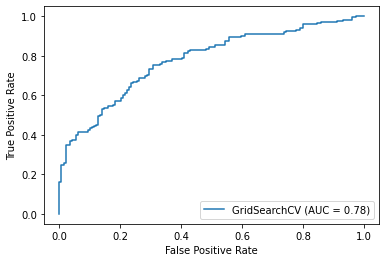

Max AUC-valued cut
{'Accuracy': 0.80625, 'Precision': 0.8187134502923976, 'Recall': 0.8187134502923976, 'F1': 0.8187134502923976, 'AUC': 0.8053298795086149}


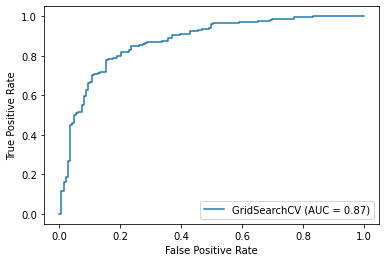

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7125, 'Precision': 0.7309941520467836, 'Recall': 0.7309941520467836, 'F1': 0.7309941520467838, 'AUC': 0.7111346599160092}


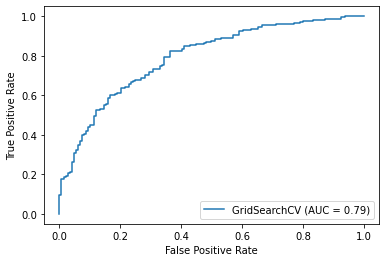

Max AUC-valued cut
{'Accuracy': 0.775, 'Precision': 0.8278145695364238, 'Recall': 0.7309941520467836, 'F1': 0.7763975155279503, 'AUC': 0.7782487538757408}


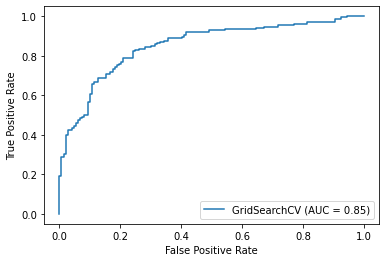

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.6823104693140795, 'Precision': 0.7019867549668874, 'Recall': 0.7114093959731543, 'F1': 0.7066666666666666, 'AUC': 0.6799234479865772}


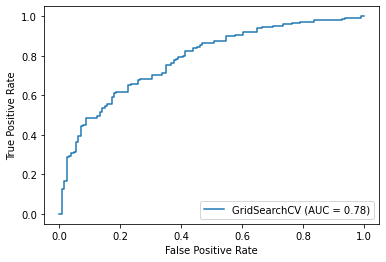

Max AUC-valued cut
{'Accuracy': 0.7653429602888087, 'Precision': 0.8088235294117647, 'Recall': 0.738255033557047, 'F1': 0.7719298245614035, 'AUC': 0.7675650167785235}


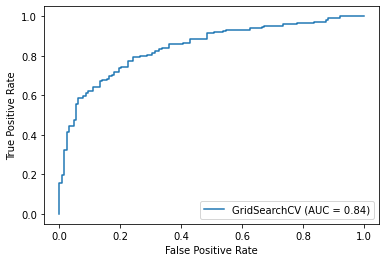

In [9]:
# Print the calculated results in a tabular way
plotCalculatedResults(logisticRegressionCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(logisticRegressionCalculatedResults, logisticRegressionResults)    

### K-Nearest-Neighbor execution

In [10]:
print("Running K-Nearest-Neighbor...")

# Execute logistic regression for each cut of each dataset and get the results.
KNNResults = runModel(doKNN)

# Get the calculated mean, the min and the max for every metric.
KNNCalculatedResults = processAlgorithmResults(KNNResults)

Running K-Nearest-Neighbor...
Start for Normalized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for Standardized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for BetterFE dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5


### K-Nearest-Neighbor summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.778125  0.768421  0.795322  0.793003  0.776855
Max   0.815625  0.814607  0.853801  0.830946  0.813238
Mean    0.7925  0.789882  0.833918  0.811088  0.789442

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min    0.76875   0.77095  0.807018  0.788571  0.765925
Max   0.853125  0.840659  0.894737  0.866856  0.850053
Mean  0.815625  0.805791  0.863158  0.833387  0.812116

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.790614  0.779141  0.812081  0.814103  0.785549
Max   0.823105  0.846154   0.85906  0.837209  0.821256
Mean   0.80722   0.80909  0.841611  0.824576  0.804399

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.778125, 'Precision': 0.7906976744186046, 'Recall': 0.7953216374269005, 'F1': 0.7930029154518949, 'AUC': 0.7768554495859334}


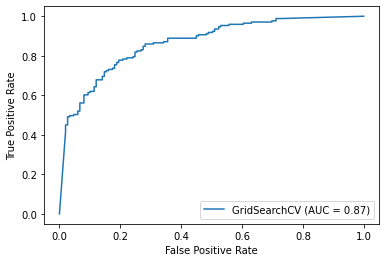

Max AUC-valued cut
{'Accuracy': 0.815625, 'Precision': 0.8146067415730337, 'Recall': 0.847953216374269, 'F1': 0.830945558739255, 'AUC': 0.8132383531535775}


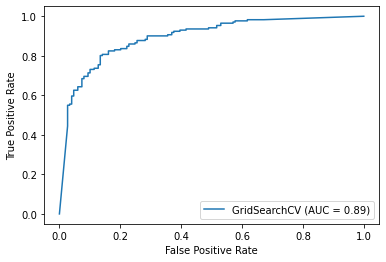

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.76875, 'Precision': 0.770949720670391, 'Recall': 0.8070175438596491, 'F1': 0.7885714285714286, 'AUC': 0.7659248793123749}


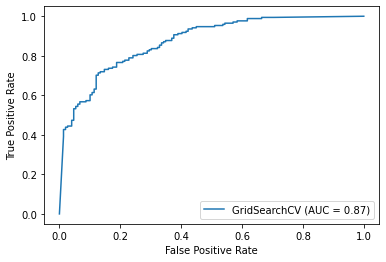

Max AUC-valued cut
{'Accuracy': 0.853125, 'Precision': 0.8406593406593407, 'Recall': 0.8947368421052632, 'F1': 0.8668555240793201, 'AUC': 0.8500529848110209}


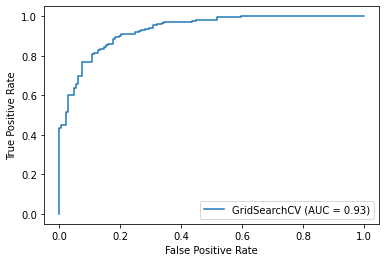

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7906137184115524, 'Precision': 0.7791411042944786, 'Recall': 0.8523489932885906, 'F1': 0.8141025641025642, 'AUC': 0.7855494966442953}


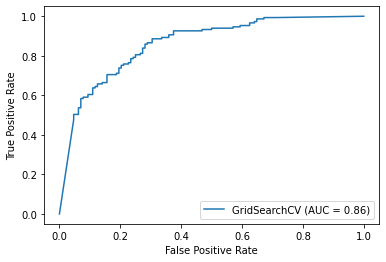

Max AUC-valued cut
{'Accuracy': 0.8231046931407943, 'Precision': 0.8289473684210527, 'Recall': 0.8456375838926175, 'F1': 0.8372093023255816, 'AUC': 0.8212562919463087}


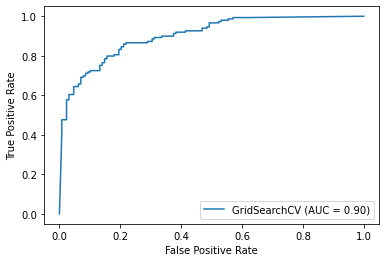

In [11]:
# Print the calculated results in a tabular way
plotCalculatedResults(KNNCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(KNNCalculatedResults, KNNResults)

### Decision Tree execution

In [12]:
print("Running Decision Tree...")

# Execute logistic regression for each cut of each dataset and get the results.
decisionTreeResults = runModel(doDecisionTree)

# Get the calculated mean, the min and the max for every metric.
decisionTreeCalculatedResults = processAlgorithmResults(decisionTreeResults)

Running Decision Tree...
Start for Normalized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for Standardized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for BetterFE dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5


### Decision Tree summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.721875  0.732955  0.754386  0.743516  0.719475
Max     0.7875   0.78453  0.830409  0.806818  0.784332
Mean  0.753125  0.755498  0.795322  0.774755   0.75001

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min    0.71875  0.739645  0.730994  0.735294  0.717846
Max    0.78125  0.797619  0.853801   0.80663  0.778484
Mean  0.758125  0.766465  0.787135  0.776204  0.755983

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.743682  0.759259  0.724832  0.752613  0.745229
Max   0.772563  0.808824  0.832215  0.797428   0.76767
Mean  0.759567  0.775856  0.779866  0.776746  0.757902

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.721875, 'Precision': 0.7329545454545454, 'Recall': 0.7543859649122807, 'F1': 0.7435158501440922, 'AUC': 0.7194748616507713}


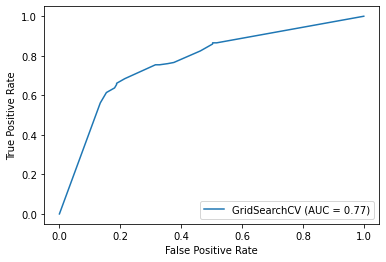

Max AUC-valued cut
{'Accuracy': 0.7875, 'Precision': 0.7845303867403315, 'Recall': 0.8304093567251462, 'F1': 0.8068181818181817, 'AUC': 0.7843321951410966}


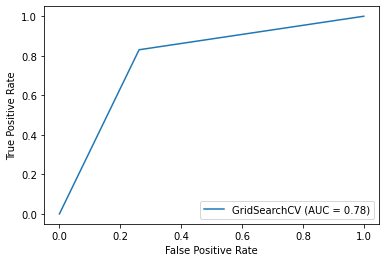

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.71875, 'Precision': 0.7396449704142012, 'Recall': 0.7309941520467836, 'F1': 0.735294117647059, 'AUC': 0.7178460693119824}


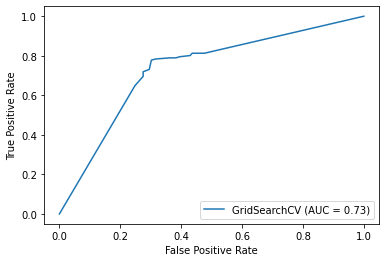

Max AUC-valued cut
{'Accuracy': 0.78125, 'Precision': 0.7821229050279329, 'Recall': 0.8187134502923976, 'F1': 0.7999999999999998, 'AUC': 0.7784842419247224}


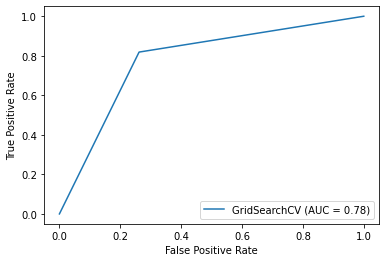

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7436823104693141, 'Precision': 0.782608695652174, 'Recall': 0.7248322147651006, 'F1': 0.7526132404181185, 'AUC': 0.7452286073825503}


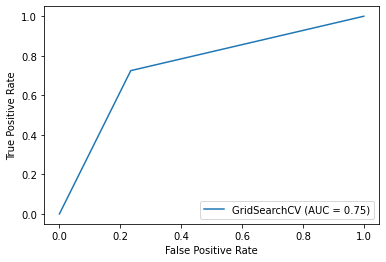

Max AUC-valued cut
{'Accuracy': 0.7725631768953068, 'Precision': 0.7654320987654321, 'Recall': 0.8322147651006712, 'F1': 0.797427652733119, 'AUC': 0.7676698825503356}


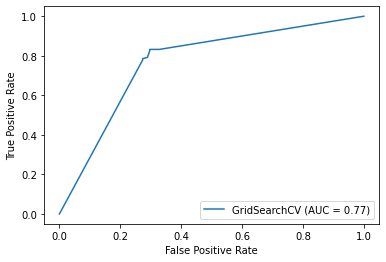

In [13]:
# Print the calculated results in a tabular way
plotCalculatedResults(decisionTreeCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(decisionTreeCalculatedResults, decisionTreeResults) 

### Neural Network execution

In [14]:
print("Running Neural Network...")

# Execute logistic regression for each cut of each dataset and get the results.
neuralNetworkResults = runModel(doNeuralNetwork)

# Get the calculated mean, the min and the max for every metric.
neuralNetworkCalculatedResults = processAlgorithmResults(neuralNetworkResults)

Running Neural Network...
Start for Normalized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for Standardized dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5
Start for BetterFE dataset
	Done cut 1
	Done cut 2
	Done cut 3
	Done cut 4
	Done cut 5


### Neural Network summary

Normalized dataset metrics summary
     Accuracy Precision    Recall        F1       AUC
Min     0.725  0.757576  0.695906  0.730061  0.727148
Max   0.80625  0.804878  0.859649  0.825843  0.802308
Mean     0.76  0.784452  0.759064  0.770794  0.760069

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.721875  0.738372   0.74269  0.740525  0.720338
Max        0.8  0.812865  0.812865  0.812865   0.79905
Mean  0.763125   0.77485  0.784795  0.779726  0.761525

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC
Min   0.736462  0.767606  0.718121  0.749141  0.736866
Max   0.779783  0.804511  0.818792       0.8  0.779336
Mean  0.761733  0.786513  0.765101  0.775127  0.761457

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.725, 'Precision': 0.7677419354838709, 'Recall': 0.695906432748538, 'F1': 0.7300613496932515, 'AUC': 0.7271478472467523}


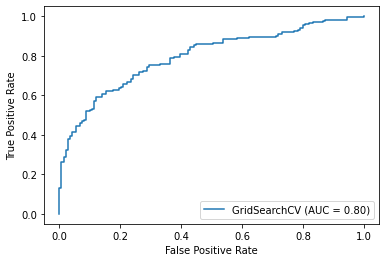

Max AUC-valued cut
{'Accuracy': 0.80625, 'Precision': 0.7945945945945946, 'Recall': 0.8596491228070176, 'F1': 0.8258426966292136, 'AUC': 0.8023077828800188}


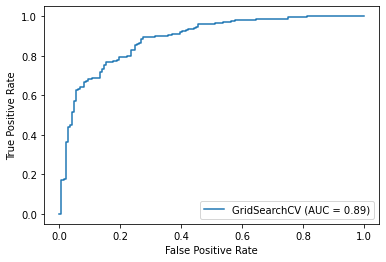

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.721875, 'Precision': 0.7383720930232558, 'Recall': 0.7426900584795322, 'F1': 0.7405247813411079, 'AUC': 0.7203383178303701}


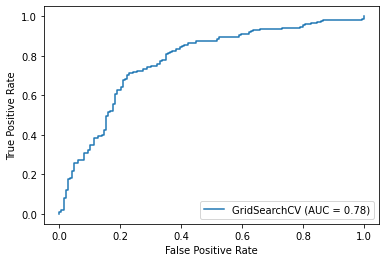

Max AUC-valued cut
{'Accuracy': 0.8, 'Precision': 0.8128654970760234, 'Recall': 0.8128654970760234, 'F1': 0.8128654970760234, 'AUC': 0.7990501982024412}


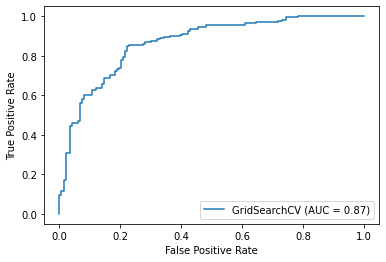

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7364620938628159, 'Precision': 0.7676056338028169, 'Recall': 0.7315436241610739, 'F1': 0.7491408934707905, 'AUC': 0.7368655620805369}


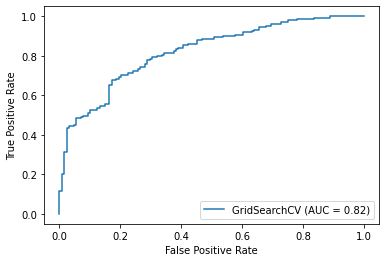

Max AUC-valued cut
{'Accuracy': 0.779783393501805, 'Precision': 0.8013698630136986, 'Recall': 0.785234899328859, 'F1': 0.7932203389830508, 'AUC': 0.7793361996644295}


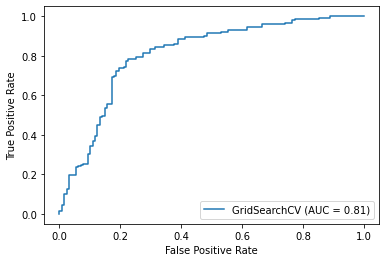

In [15]:
# Print the calculated results in a tabular way
plotCalculatedResults(neuralNetworkCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(neuralNetworkCalculatedResults, neuralNetworkResults) 

In [16]:
print("Done!")

Done!
